# Fraud Detection

In [41]:
#%% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scikitplot as skplt

%matplotlib inline

from matplotlib import pyplot
from pprint import pprint
from IPython.display import display 
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier ,AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve ,KFold
from sklearn.metrics import roc_curve,accuracy_score,f1_score,auc,confusion_matrix,roc_auc_score,plot_confusion_matrix
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("/Users/cameronlooney/Downloads/PS_20174392719_1491204439457_log.csv")

In [3]:
print(df.shape[0])

6362620


In [4]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.columns = map(str.lower, df.columns)

## 1.0 Data Overview

With most datasets I like to get an overview of the data with some high level analysis / checks

### 1.1 Missing Data

In [6]:
def missing_values(data):
    '''
    :param data: dataframe
    :return: dataframe with features, number of missing values and percentage of missing values,
    sort the dataframe by number of missing values
    '''
    missing_values = pd.DataFrame(data.isnull().sum()).reset_index()
    missing_values.columns = ['feature', 'missing_values']
    missing_values['percentage_missing_values'] = (missing_values['missing_values'] / len(data)) * 100
    missing_values = missing_values.sort_values('missing_values', ascending=False)
    return missing_values
print(missing_values(df))

           feature  missing_values  percentage_missing_values
0             step               0                        0.0
1             type               0                        0.0
2           amount               0                        0.0
3         nameorig               0                        0.0
4    oldbalanceorg               0                        0.0
5   newbalanceorig               0                        0.0
6         namedest               0                        0.0
7   oldbalancedest               0                        0.0
8   newbalancedest               0                        0.0
9          isfraud               0                        0.0
10  isflaggedfraud               0                        0.0


We have no missing data so we dont have to worry about imputating values

### 1.2 Unique Values

In [7]:
print(df.nunique(axis=0))

step                  743
type                    5
amount            5316900
nameorig          6353307
oldbalanceorg     1845844
newbalanceorig    2682586
namedest          2722362
oldbalancedest    3614697
newbalancedest    3555499
isfraud                 2
isflaggedfraud          2
dtype: int64


In [8]:
print(df.dtypes)

step                int64
type               object
amount            float64
nameorig           object
oldbalanceorg     float64
newbalanceorig    float64
namedest           object
oldbalancedest    float64
newbalancedest    float64
isfraud             int64
isflaggedfraud      int64
dtype: object


Can change isfraud and isflaggedfraud to categories, these will be the values we are predicting. I'm undecided about if I will keep the isflaggedfraud column, It gives inside information to the value we are trying to predict. <br>
nameorig and namedest are both strings, this will make encoding challenging as One Hot Encoding would generate millions of features due to the number of unique values. Label Encoding would signify that there is some hierarchical structure to the column which isnt the case.

### 1.3 Descriptive Statistics

In [9]:
pd.set_option('display.float_format', str)

In [10]:
print(df.describe())

                    step             amount      oldbalanceorg  \
count          6362620.0          6362620.0          6362620.0   
mean  243.39724563151657 179861.90354912292  833883.1040744851   
std   142.33197104914032  603858.2314629931 2888242.6730066556   
min                  1.0                0.0                0.0   
25%                156.0           13389.57                0.0   
50%                239.0           74871.94            14208.0   
75%                335.0        208721.4775         107315.175   
max                743.0        92445516.64        59585040.37   

          newbalanceorig     oldbalancedest     newbalancedest  \
count          6362620.0          6362620.0          6362620.0   
mean   855113.6685785672 1100701.6665196999 1224996.3982020712   
std   2924048.5029707146 3399180.1129690637  3674128.942093883   
min                  0.0                0.0                0.0   
25%                  0.0                0.0                0.0   
50%      

## 2.0 Exploratory Data Analysis

0    6354407
1       8213
Name: isfraud, dtype: int64
0     99.87091795518198
1   0.12908204481801522
Name: isfraud, dtype: float64


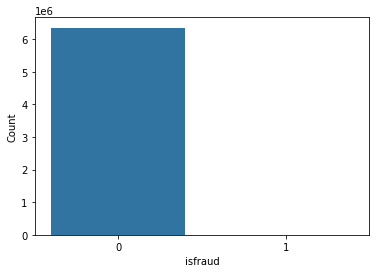

In [11]:
# count number of fraud and not fraud data
print(df["isfraud"].value_counts())
print(df["isfraud"].value_counts()/len(df.index)*100)
sns.countplot(data=df, x='isfraud')
plt.ylabel('Count')
plt.show()

We have an ETREMELY unbalanced dataset, we must consider this when we are splitting our data to ensure that we get even porportions in our training and test data. <br>
To accomplish this we can use stratified sampling, this techniques basically will ensure that both the test and training data have equal splits of Fraud/ not Fraud <br>
This is vital as without we can end up overfitting to the training data

0    6362604
1         16
Name: isflaggedfraud, dtype: int64
0      99.99974853126542
1   0.000251468734577894
Name: isflaggedfraud, dtype: float64


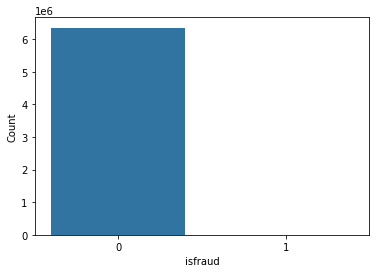

In [12]:
print(df["isflaggedfraud"].value_counts())
print(df["isflaggedfraud"].value_counts()/len(df.index)*100)
sns.countplot(data=df, x='isfraud')
plt.ylabel('Count')
plt.show()

Im perplexed by this feature, it only has 16 cases of fraud, if all the flagged cases were indeed fraud, this would mean the previous system had a 0.19% detection rate. We will drop this column as it will provide no information for our model

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64
CASH_OUT    35.16633085112736
PAYMENT     33.81460781879163
CASH_IN    21.992261049693365
TRANSFER    8.375621992198184
DEBIT      0.6511782881894566
Name: type, dtype: float64


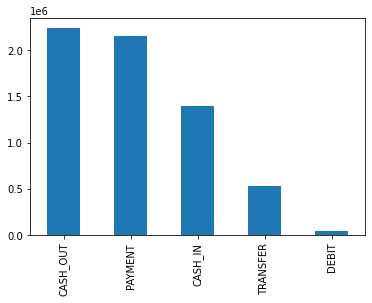

In [13]:
print(df.type.value_counts())
df.type.value_counts().plot(kind='bar')
print(df["type"].value_counts()/len(df.index)*100)
plt.show()

We have 5 buckets of payment types, the types are inbalanced with cash_out and payment making up nearly 70% of transactions.

In [14]:
#Groupby type
df.groupby('type')['isfraud'].sum()

type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isfraud, dtype: int64

Interestly fraud appears to only occur in two categories, cash out and payment. This makes some bit of sense as they are overepresented in the data, however I did expect other categories to have zero cases. (Besides cash in as Im pretty sure if someone wants to give us free money we will be okay with it

In [15]:
# custom function for easy and efficient analysis of numerical univariate
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
def UVA_numeric(data, var_group):
    size = len(var_group)
    plt.figure(figsize = (7*size,3), dpi = 100)
  
    #looping for each variable
    for j,i in enumerate(var_group):

    # calculating descriptives of variable
        mini = data[i].min()
        maxi = data[i].max()
        ran = data[i].max()-data[i].min()
        mean = data[i].mean()
        median = data[i].median()
        st_dev = data[i].std()
        skew = data[i].skew()
        kurt = data[i].kurtosis()

        # calculating points of standard deviation
        points = mean-st_dev, mean+st_dev

        #Plotting the variable with every information
        plt.subplot(1,size,j+1)
        sns.kdeplot(data[i], shade=True)
        sns.lineplot(points, [0,0], color = 'black', label = "std_dev")
        sns.scatterplot([mini,maxi], [0,0], color = 'orange', label = "min/max")
        sns.scatterplot([mean], [0], color = 'red', label = "mean")
        sns.scatterplot([median], [0], color = 'blue', label = "median")
        plt.xlabel('{}'.format(i), fontsize = 20)
        plt.ylabel('density')
        plt.title('std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                       round(kurt,2),
                                                                                                       round(skew,2),
                                                                                                       (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                       round(mean,2),
                                                                                                       round(median,2)))

        

In [16]:
def get_dtypes(data,drop_col=[]):
    """Return the dtypes for each column of a pandas Dataframe
    Parameters
    ----------
    data : pandas Dataframe
    drop_col : columns to omit in a list
    Returns
    -------
    str_var_list, num_var_list, all_var_list
    
    """

    name_of_col = list(data.columns)
    num_var_list = []
    str_var_list = []
    all_var_list = []

    str_var_list = name_of_col.copy()
    for var in name_of_col:
        # check if column belongs to numeric type
        if (data[var].dtypes in (np.int, np.int64, np.uint, np.int32, np.float,
                               np.float64, np.float32, np.double)):
            str_var_list.remove(var)
            num_var_list.append(var)
    # drop the omit column from list
    for var in drop_col:
        if var in str_var_list:
            str_var_list.remove(var)
        if var in num_var_list:
            num_var_list.remove(var)

    all_var_list.extend(str_var_list)
    all_var_list.extend(num_var_list)
    
    return str_var_list, num_var_list, all_var_list
string_vars, num_vars,all_vars = get_dtypes(df)

In [17]:
num_vars

['step',
 'amount',
 'oldbalanceorg',
 'newbalanceorig',
 'oldbalancedest',
 'newbalancedest',
 'isfraud',
 'isflaggedfraud']

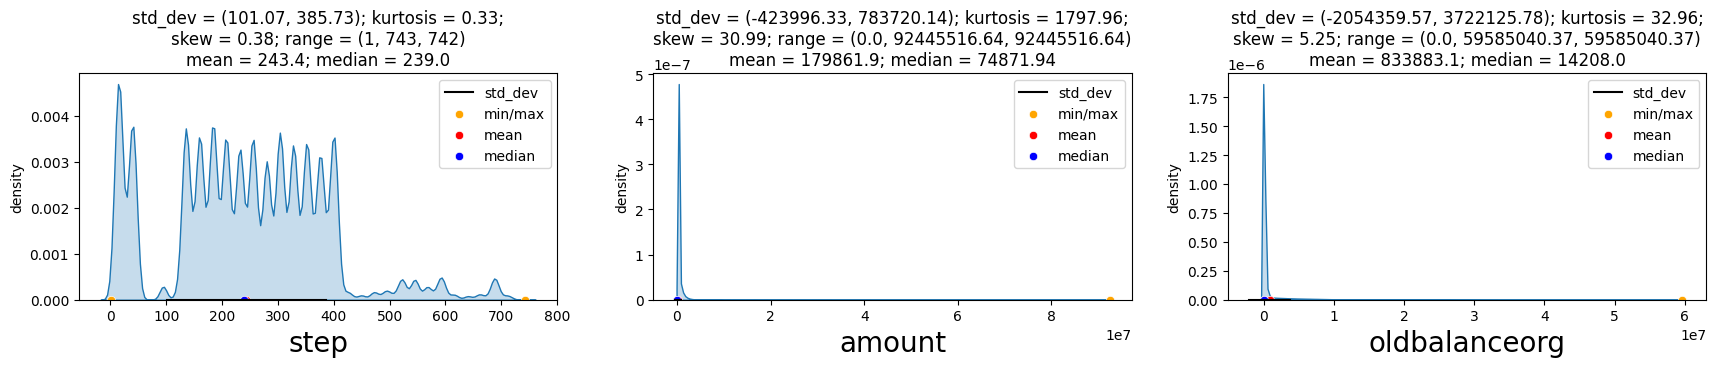

In [18]:
UVA_numeric(df,
            ['step',
 'amount',
 'oldbalanceorg'])

Both amount and oldbalanceorg have extreme right tailed outliers

In [19]:
string_vars

['type', 'nameorig', 'namedest']

In [20]:
# Custom function for easy visualisation of Categorical Variables
def UVA_category(data, var_group):
    size = len(var_group)
    plt.figure(figsize = (7*size,5), dpi = 100)

    # for every variable
    for j,i in enumerate(var_group):
        norm_count = data[i].value_counts(normalize = True)
        n_uni = data[i].nunique()

        #Plotting the variable with every information
        plt.subplot(1,size,j+1)
        sns.barplot(norm_count, norm_count.index , order = norm_count.index)
        plt.xlabel('fraction/percent', fontsize = 20)
        plt.ylabel('{}'.format(i), fontsize = 20)
        plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))
        



In [21]:
#UVA_category(df,string_vars)

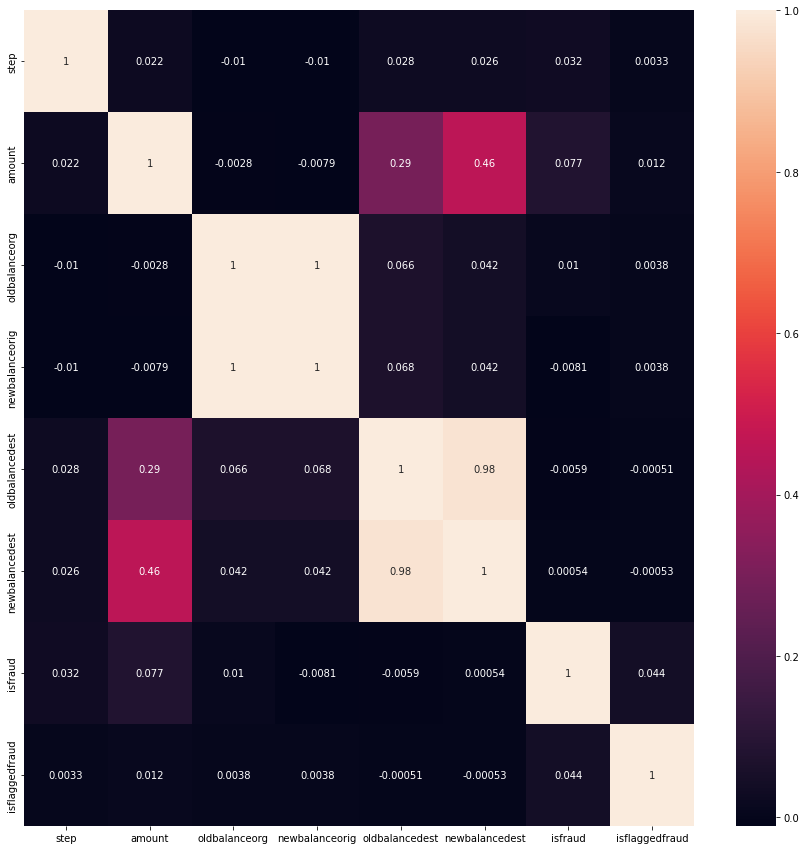

In [22]:
def correlation_matrix(data,width,height):
    '''
    :param data: dataframe
    :return: correlation matrix with heatmap
    '''
    plt.figure(figsize=(width, height))
    sns.heatmap(data.corr(), annot=True)

correlation_matrix(df,15,15)

## Feature Engineering

We are going to drop several columns as from EDA we see they wont bring much or any value to our model

In [23]:
df = df.drop(['nameorig', 'namedest', 'isflaggedfraud'], axis = 1)

As we have over 6 million records and Fraud doesnt appear in any type outside of transfer and cash out we can use just these categories in our model as its safe to assume that we wont see fraud in our types 

**Difference in balance**:We would expect when money is sent or recieved that the balance will change by roughly this amount, assuming minimal or no charges for sending or recieving money <br>
**Surge indicator:** We saw from our distribution chart of amount we have some large amounts (outliers), thus we will consider the transaction suspicious if the amount is considered an outlier <br>
**Frequency indicator:** A customer who is recieving money from a large number of accounts may be considered suspcious<br>
**Merchant indicator:** The customer ids in receiver starts with 'M' which means that they are merchants and they obviously will have a lot of receiving transactions. Thus this should negate the frequency filter

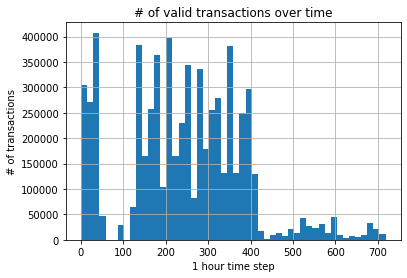

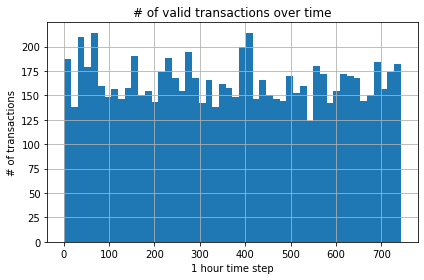

In [25]:
# Time patterns

bins = 50
df_valid = df.loc[df['isfraud'] == 0]
df_fraud =  df.loc[df['isfraud'] == 1]
df_valid.hist(column="step",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")

df_fraud.hist(column="step",bins=bins)
plt.xlabel("1 hour time step")
plt.ylabel("# of transactions")
plt.title("# of valid transactions over time")


plt.tight_layout()
plt.show()

Valid transactions tend to occur between 0-60 in the step column and again between 100-400. <br>
On the other hand fraud tends to have a uniform distribution, occuring evenly across the timeframe

Calculating the error in balance between account transactions, those where there is an error are more likely to be fraud

In [26]:
df["errorbalanceOrg"] = df.newbalanceorig + df.amount - df.oldbalanceorg
df["errorbalanceDest"] = df.oldbalancedest + df.amount - df.newbalancedest

In [27]:
# Subsetting data into observations with fraud and valid transactions:
fraud = df[df["isfraud"] == 1]
valid = df[df["isfraud"] == 0]

In [28]:
print("Proportion of fraudulent transactions with errorBalanceDest > 0: ", len(fraud[fraud.errorbalanceDest > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceDest > 0: ", len(valid[valid.errorbalanceDest > 0])/len(valid))
print("Proportion of fraudulent transactions with errorBalanceOrg > 0: ", len(fraud[fraud.errorbalanceOrg > 0])/len(fraud))
print("Proportion of valid transactions with errorBalanceOrg > 0: ", len(valid[valid.errorbalanceOrg > 0])/len(valid))

Proportion of fraudulent transactions with errorBalanceDest > 0:  0.5712894192134421
Proportion of valid transactions with errorBalanceDest > 0:  0.6413928160408988
Proportion of fraudulent transactions with errorBalanceOrg > 0:  0.006331425788384269
Proportion of valid transactions with errorBalanceOrg > 0:  0.8036598851789003


Im not too sure how much of a difference converting the step function from hours to days will do but i think it increases interpretability

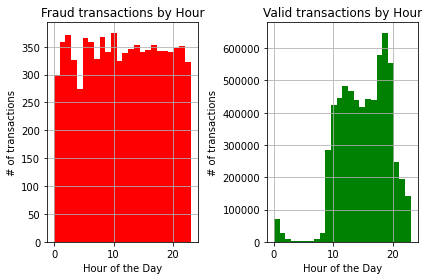

In [30]:
# plotting scatterplot of the hours of days, identifying the fraudulent transactions (red) from the valid transactions (green) 
plt.subplot(1, 2, 1)
fraud_hours.hist(bins=num_hours, color="red")
plt.title('Fraud transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")


plt.subplot(1, 2, 2)
valid_hours.hist(bins=num_hours, color="green")
plt.title('Valid transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel("# of transactions")

plt.tight_layout()
plt.show()

This actually gives us great insight. The vast majority of valid transactions occur between rough 10am and 8pm. While the fraud transactions are uniformly spread out, thus if its an outside of trading hours transaction there is a higher chance of the transaction being fraud. Thus this might be worth adding to our model

In [32]:
dataset = df.copy()


# adding feature HourOfDay to Dataset1 
dataset["HourOfDay"] = np.nan # initializing feature column
dataset.HourOfDay = df.step % 24


print("Head of dataset1: \n", pd.DataFrame.head(dataset))

Head of dataset1: 
    step      type   amount  oldbalanceorg  newbalanceorig  oldbalancedest  \
0     1   PAYMENT  9839.64       170136.0       160296.36             0.0   
1     1   PAYMENT  1864.28        21249.0        19384.72             0.0   
2     1  TRANSFER    181.0          181.0             0.0             0.0   
3     1  CASH_OUT    181.0          181.0             0.0         21182.0   
4     1   PAYMENT 11668.14        41554.0        29885.86             0.0   

   newbalancedest  isfraud  errorbalanceOrg  errorbalanceDest  HourOfDay  
0             0.0        0              0.0           9839.64          1  
1             0.0        0              0.0           1864.28          1  
2             0.0        1              0.0             181.0          1  
3             0.0        1              0.0           21363.0          1  
4             0.0        0              0.0          11668.14          1  


### Missing Data

There is actually no missing data so we can skip this step

### Categorical Data

We only have one categorical feature to contend with, it has a low cardinality and isnt hierarchical so we will perform one hot encoding

In [35]:
dataset = pd.get_dummies(dataset,prefix=['type'])

In [36]:
dataset.head()

,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud,errorbalanceOrg,errorbalanceDest,HourOfDay,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,1,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,1,0,0,0,1,0
2,1,181.0,181.0,0.0,0.0,0.0,1,0.0,181.0,1,0,0,0,0,1
3,1,181.0,181.0,0.0,21182.0,0.0,1,0.0,21363.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,1,0,0,0,1,0


We will see if Min max scaling makes a difference

In [44]:
y = dataset['isfraud']
X = dataset.drop('isfraud',errors='ignore',axis=1)
dataset.columns

Index(['step', 'amount', 'oldbalanceorg', 'newbalanceorig', 'oldbalancedest',
       'newbalancedest', 'isfraud', 'errorbalanceOrg', 'errorbalanceDest',
       'HourOfDay', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 0, shuffle= True,stratify = y)
# By using a stratified split, the raito of 1 and 0s are consistent btwn the two splits 
print(y_train.value_counts())
print(y_test.value_counts())

0    5718966
1       7392
Name: isfraud, dtype: int64
0    635441
1       821
Name: isfraud, dtype: int64


In [48]:
from sklearn.tree import DecisionTreeClassifier # Decision tree algorithm
from sklearn.ensemble import RandomForestClassifier # Random forest tree algorithm
from xgboost import XGBClassifier # XGBoost algorithm
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, roc_curve, auc, precision_score

In [53]:
# Train model
parametersRF = {'n_estimators':15,'class_weight': "balanced",'n_jobs':-1,'random_state':42}
RF = RandomForestClassifier(**parametersRF)
fitted_vals_RF = RF.fit(X_train, y_train)
 
# Predict on testing set
predictionsRF = RF.predict(X_test)
 
     
# Evaluating model
CM_RF = confusion_matrix(y_test,predictionsRF)
CR_RF = classification_report(y_test,predictionsRF)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, predictionsRF)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

# showing results from Random Forest

for measure in resultsRF:
    print(measure,": \n",resultsRF[measure])

Confusion Matrix : 
 [[635441      0]
 [     2    819]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       1.00      1.00      1.00       821

    accuracy                           1.00    636262
   macro avg       1.00      1.00      1.00    636262
weighted avg       1.00      1.00      1.00    636262

Area Under Curve : 
 0.9987819732034104


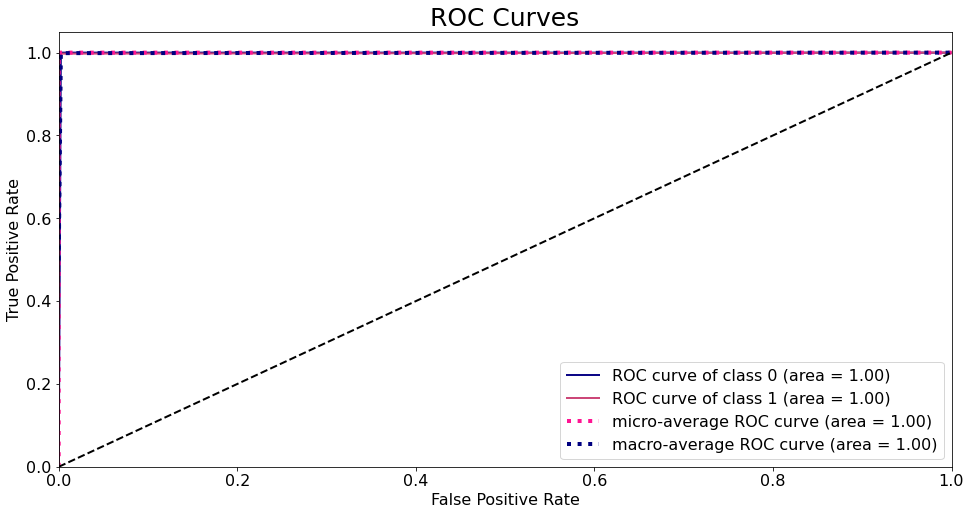

Overall AUC: 0.999


In [54]:
def ROC_curve(model,X_test, y_test):
    y_true = y_test # ground truth label
    y_probas = model.predict_proba(X_test) # predicted probabilities generated by sklearn classifier

    skplt.metrics.plot_roc(y_true, y_probas, figsize=(16,8), title_fontsize=25, text_fontsize=16, cmap='plasma')
    plt.grid(False)
    plt.show()
    score = roc_auc_score(y_test,model.predict(X_test))
    print("Overall AUC: {:.3f}" .format(score))
ROC_curve(fitted_vals_RF,X_test,y_test)

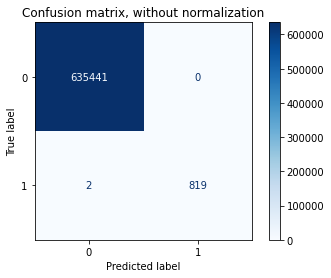

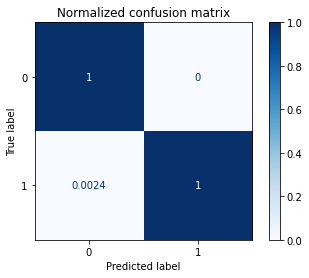

In [57]:
def c_matrix(df):
    # Plot Both Confusion Matrix, without normalization and with normalization 
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(df, X_test, y_test,
                                     display_labels=df.classes_,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

    plt.show()
c_matrix(fitted_vals_RF)

/var/folders/yt/tb5v0shj3l17fyn2bw5qqw3h0000gn/T/ipykernel_45918/3941159733.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(best_vars, size=12)


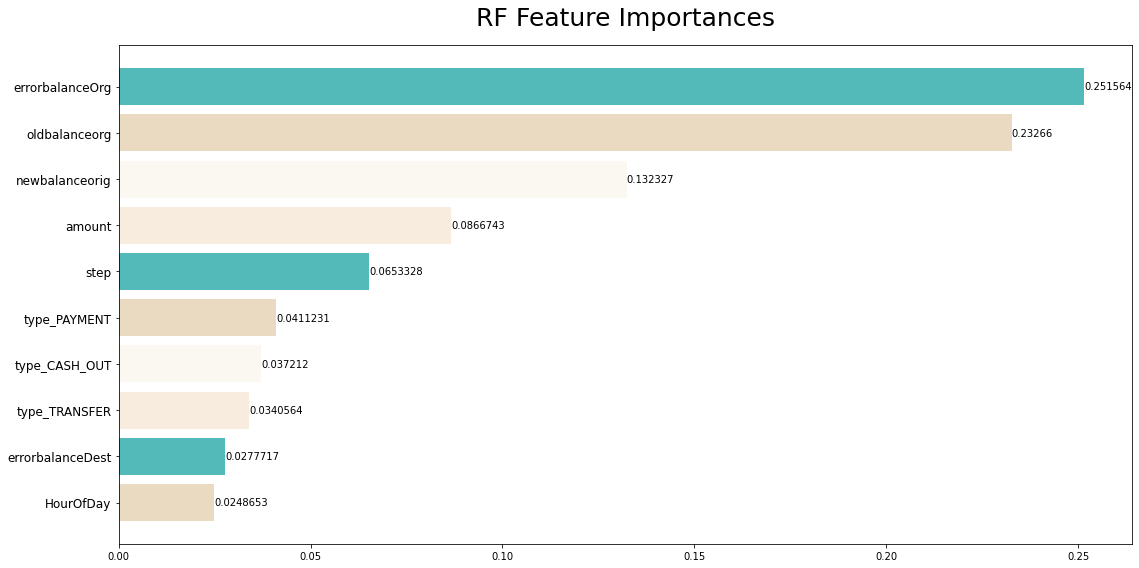

In [60]:
def feature_importance_plot(fitted_model,model_name,req_cols,num_features_plot):
    model = fitted_model
    features_to_plot = num_features_plot

    importances = model.feature_importances_
    indices = np.argsort(importances)

    best_vars = np.array(req_cols)[indices][-features_to_plot:]
    values = importances[indices][-features_to_plot:]
    best_vars

    y_ticks = np.arange(0, features_to_plot)
    fig, ax = plt.subplots(figsize=(16,8))
    ax.barh(y_ticks, values, color=['#E9DAC1','#54BAB9','#F7ECDE','#FBF8F1'])
    ax.set_yticklabels(best_vars, size=12)
    ax.set_yticks(y_ticks)
    ax.set_title("{} Feature Importances".format(str(model_name)), size=25, pad=20, color='black')
    ax.bar_label(ax.containers[0], size="10")
    fig.tight_layout()
    plt.grid(False)
    plt.show()
    
feature_importance_plot(fitted_vals_RF,"RF",X.columns,10)

Only two cases of fraud were missed

In [49]:
# Train model
DT = DecisionTreeClassifier()
fitted_vals = DT.fit(X_train, y_train)
 
# Predict on testing set
predictionsDT = DT.predict(X_test)
 
     
# Evaluating model
CM_DT = confusion_matrix(y_test,predictionsDT)
CR_DT = classification_report(y_test,predictionsDT)
fprDT, recallDT, thresholdsDT = roc_curve(y_test, predictionsDT)
AUC_DT = auc(fprDT, recallDT)

resultsDT = {"Confusion Matrix":CM_DT,"Classification Report":CR_DT,"Area Under Curve":AUC_DT}

# showing results from Random Forest

for measure in resultsDT:
    print(measure,": \n",resultsDT[measure])

Confusion Matrix : 
 [[635437      4]
 [     2    819]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       1.00      1.00      1.00       821

    accuracy                           1.00    636262
   macro avg       1.00      1.00      1.00    636262
weighted avg       1.00      1.00      1.00    636262

Area Under Curve : 
 0.9987788257829576


In [50]:
# Train model
parametersXGB = {'max_depth':3,'class_weight': "balanced",'n_jobs':-1,'random_state':42,'learning_rate':0.1}
XGB = XGBClassifier(**parametersXGB)
    
    
fitted_vals = XGB.fit(X_train, y_train)
 
# Predict on testing set
predictionsXGB = XGB.predict(X_test)
 
     
# Evaluating model
CM_XGB = confusion_matrix(y_test,predictionsXGB)
CR_XGB = classification_report(y_test,predictionsXGB)
fprXGB, recallXGB, thresholds_XGB = roc_curve(y_test, predictionsXGB)
AUC_XGB = auc(fprXGB, recallXGB)
resultsXGB = {"Confusion Matrix":CM_XGB,"Classification Report":CR_XGB,"Area Under Curve":AUC_XGB}
# showing results from Extreme Gradient Boosting
for measure in resultsXGB:
    print(measure,": \n",resultsXGB[measure],"\n")

[21:09:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-3.7/xgboost/src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Confusion Matrix : 
 [[635441      0]
 [     2    819]] 

Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    635441
           1       1.00      1.00      1.00       821

    accuracy                           1.00    636262
   macro avg       1.00      1.00      1.00    636262
weighted avg       1.00      1.00      1.00    636262
 

Area Under Curve : 
 0.9987819732034104 



## Conclusion 
All Models performed extremely well, AUC for Random Forest was near 1 with only two frauds missed so it will be our chosen model

In [63]:
X.columns

Index(['step', 'amount', 'oldbalanceorg', 'newbalanceorig', 'oldbalancedest',
       'newbalancedest', 'errorbalanceOrg', 'errorbalanceDest', 'HourOfDay',
       'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER'],
      dtype='object')

In [65]:
import pickle

In [67]:
with open('/Users/cameronlooney/PyCharm/Fraud/my_model.pkl', 'wb') as file:  
    pickle.dump(fitted_vals_RF, file)

['/Users/cameronlooney/PyCharm/Fraud/credit_fraud.pkl']